# HMIS Data Quality Analysis
***

# Preprocessing

In [ ]:
# dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats

Read in the data:

In [2]:
df = pd.read_csv('Performance of Key HMIS Indicators for Maharashtra(FY 2018-2019).csv', header = [0, 1])

Some preprocessing:

In [3]:
a = df.columns.get_level_values(0).to_series()
b = a.mask(a.str.startswith('Unnamed')).ffill().fillna('')
df.columns = [b, df.columns.get_level_values(1)]

df.rename({'Unnamed: 0_level_1':'State'}, axis='columns', inplace=True)

df = df.set_index(('Indicators', 'State')).rename_axis('State')

In [4]:
# display the dataframe
df

Total number of pregnant women Registered for ANC             \
                                                        2018-19    2017-18   
State                                                                        
_Maharashtra                                          16,54,843  16,27,916   
Ahmadnagar                                               76,101     64,755   
Akola                                                    23,871     24,613   
Amravati                                                 33,273     35,012   
Aurangabad                                               59,464     63,780   
Bhandara                                                 12,238     12,945   
Bid                                                      35,295     37,276   
Brihan Mumbai                                          1,99,705   2,06,464   
Buldana                                                  37,376     37,597   
Chandrapur                                               22,758     24,243   
Dhule                                                    35,780     35,169   
Gadchiroli                                               13,569     15,193   
Gondiya                                                  14,752     15,291   
Hingoli                                                  17,057     16,743   
Jalgaon                                                  59,418     58,376   
Jalna                                                    30,990     32,411   
Kolhapur                                                 44,300     49,185   
Latur                                                    34,865     36,845   
Nagpur                                                   65,801     65,507   
Nanded                                                   50,340     50,786   
Nandurbar                                                27,406     26,879   
Nashik                                                 1,07,849     91,676   
Osmanabad                                                21,050     22,266   
Palghar                                                  45,439     46,683   
Parbhani                                                 28,389     26,812   
Pune                                                   1,57,438   1,45,451   
Raigarh                                                  33,159     30,956   
Ratnagiri                                                14,379     13,801   
Sangli                                                   38,518     38,991   
Satara                                                   35,546     35,084   
Sindhudurg                                                6,061      6,446   
Solapur                                                  67,557     65,543   
Thane                                                  1,45,153   1,27,757   
Wardha                                                   13,691     13,823   
Washim                                                   14,093     14,857   
Yavatmal                                                 32,162     38,700   

              Number of Pregnant women registered within first trimester  \
                                                                 2018-19   
State                                                                      
_Maharashtra                                           12,18,205           
Ahmadnagar                                                65,017           
Akola                                                     18,251           
Amravati                                                  26,855           
Aurangabad                                                52,167           
Bhandara                                                  11,371           
Bid                                                       29,020           
Brihan Mumbai                                             72,382           
Buldana                                                   30,622           
Chandrapur                                                1

Now that we have the data loaded into a dataframe, we will proceed with the analysis.

***

# Analysis of Data Quality

## Erroneous Percentages

These indicators along with the year are recorded as a percentage. Some of these indicators have a percentage over 100%. 

In [5]:
# select the max values for all indicators expressed as a percentage
series = df[df.columns.levels[0][df.columns.levels[0].str.contains('%')]].max()

# select the indicators greater than 100% and store the result
series[series.values > 100].to_csv('erroneous_percentages.csv')

***

## Regression to fill NULLs

Here we will check for isolated NULLs and demonstrate a use case of Regression to impute the missing datapoint.

Some preprocessing:

In [5]:
# get the dataframe in a tidy format
dfr = df.stack()
dfr.rename_axis(['state', 'year'], inplace = True);

In [6]:
# convert string objects to float
for col in dfr.columns:
    if dfr[col].dtype == 'O':
        dfr[col] = dfr[col].str.replace(',', '').astype(float)

The following indicators have all null values:

In [17]:
dfr.columns[dfr.isnull().all()]

Index(['Institutional Deliveries at District Hospitals',
       'Measles immunization at urban Health facilities i.e SC+PHC+CHC+SDH+DH',
       'Total Sterlisation (Tubectomies and Vasectomies) conducted at CHC',
       'Total Sterlisation (Tubectomies and Vasectomies) conducted at DH',
       'Total Sterlisation (Tubectomies and Vasectomies) conducted at PHC',
       'Total Sterlisation (Tubectomies and Vasectomies) conducted at SDH'],
      dtype='object')

The following indicators have one or more null values:

In [18]:
dfr.columns[dfr.isnull().any()]

Index(['% Female Inpatient Deaths to Total Inpatient Deaths',
       '% Laparoscopic sterlisations at Public Institutions to Total Laparoscopic Sterilisations',
       '% MTPs more than 12 weeks of Pregnancy to Total MTPs at Public Institutions',
       '% MTPs up to 12 weeks of Pregnancy to Total MTPs at Public Institutions',
       '% Post Abortion sterlisations at Public Institutions to Total Post Partum Sterilisation',
       '% Pregnant women treatd for Syphilis to Total sero positive for Syphilis',
       '% of babies treated for congenital Syphilis to babies total diagnosed with Congenital Syphilis',
       'IUCD insertions done (pvt. facilities)',
       'Institutional Deliveries at District Hospitals',
       'Institutional Deliveries at Urban Heatlh Facilities i.e SC+PHC+CHC+SDH',
       'Measles immunization at urban Health facilities i.e SC+PHC+CHC+SDH+DH',
       'Number of Infants given DPT1',
       'Number of Women Discharged under 48 hours of delivery in private instit

Exclude the columns with all nulls since those indicators are under compilation:

In [19]:
df3 = dfr[list(set(dfr.columns[dfr.isnull().any()]) - set(dfr.columns[dfr.isnull().all()]))]

Select an instance of an isolated null value:

In [26]:
df3[df3['IUCD insertions done (pvt. facilities)'].isnull()]['IUCD insertions done (pvt. facilities)']

state  year   
Bid    2017-18   NaN
Name: IUCD insertions done (pvt. facilities), dtype: float64

Select an indicator related to `IUCD insertions done (pvt. facilities)` to demonstrate use of regression to impute the above null value. In this case, select `IUCD insertions done (public facilities)`:

In [22]:
# pvt facilities
df3_1 = dfr.xs('2017-18', level = 'year')['IUCD insertions done (pvt. facilities)']

# public facilities
df3_2 = dfr.xs('2017-18', level = 'year')['IUCD Insertions done (public facilities)']

Exclude the data for state of Maharashtra and the district of Brihan Mumbai because they are both valid outliers and will skew the distribution. Also, exclude the district of Bid since we don't have the value for `IUCD insertions done (pvt. facilities)` for the same.

In [23]:
df3_1 = df3_1.drop(['_Maharashtra', 'Bid', 'Brihan Mumbai'])
df3_2 = df3_2.drop(['_Maharashtra', 'Bid', 'Brihan Mumbai'])

Get the number of `IUCD Insertions done (public facilities)` for the district of Bid:

In [40]:
dfr.xs('2017-18', level = 'year')['IUCD Insertions done (public facilities)']['Bid']

14202.0

Plot both the indicators as a scatterplot and fit a regression line through the data. Also, mark the x-value for Bid as found above.

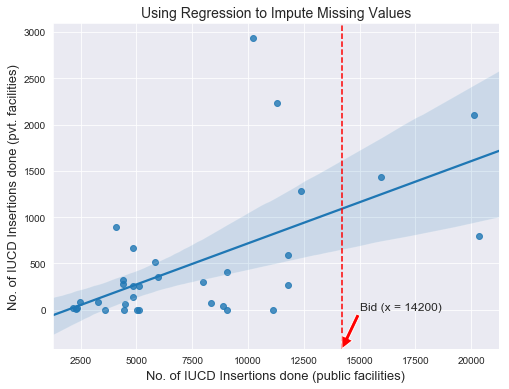

In [98]:
sb.set_style('darkgrid')

# plot
plt.figure(figsize = (8, 6))
sb.regplot(df3_2, df3_1)

# mark the x-value for Bid
plt.axvline(x = 14202, linestyle = '--', color = 'r')
plt.annotate('Bid (x = 14200)', xy=(14202.0, -425), xytext=(15000, 0),
            arrowprops=dict(facecolor='red', shrink=0.01), fontsize = 12
            )

# label the plot
plt.title('Using Regression to Impute Missing Values', fontsize = 14)
plt.xlabel('No. of IUCD Insertions done (public facilities)', fontsize = 13)
plt.ylabel('No. of IUCD Insertions done (pvt. facilities)', fontsize = 13);
plt.savefig('regression_for_missing_entries.png')

****

## Validity Issue

Here we will look for problems in the validity of the data. In this case, we will compare the indicators `Total number of pregnant women Registered for ANC` and `Number of Pregnant women given 180 IFA tablets` and focus on instances where the latter is greater than the former.

In [46]:
df1 = dfr[['Total number of pregnant women Registered for ANC', 'Number of Pregnant women given 180 IFA tablets',
    '% Pregnant women given 180 IFA to Total ANC Registration']]

Select only those percentage values greater than 100:

In [47]:
df1[df1['% Pregnant women given 180 IFA to Total ANC Registration'] > 100]

,,Total number of pregnant women Registered for ANC,Number of Pregnant women given 180 IFA tablets,% Pregnant women given 180 IFA to Total ANC Registration
state,year,,,
Bhandara,2018-19,12238.0,13659.0,111.6
Bid,2018-19,35295.0,44931.0,127.3
Dhule,2018-19,35780.0,40073.0,112.0
Jalgaon,2018-19,59418.0,61807.0,104.0
Jalna,2018-19,30990.0,32668.0,105.4
Kolhapur,2018-19,44300.0,45612.0,103.0
Latur,2018-19,34865.0,37884.0,108.7
Ratnagiri,2018-19,14379.0,15812.0,110.0
Sangli,2018-19,38518.0,43853.0,113.9


Generate a bar plot illustrating the errors:

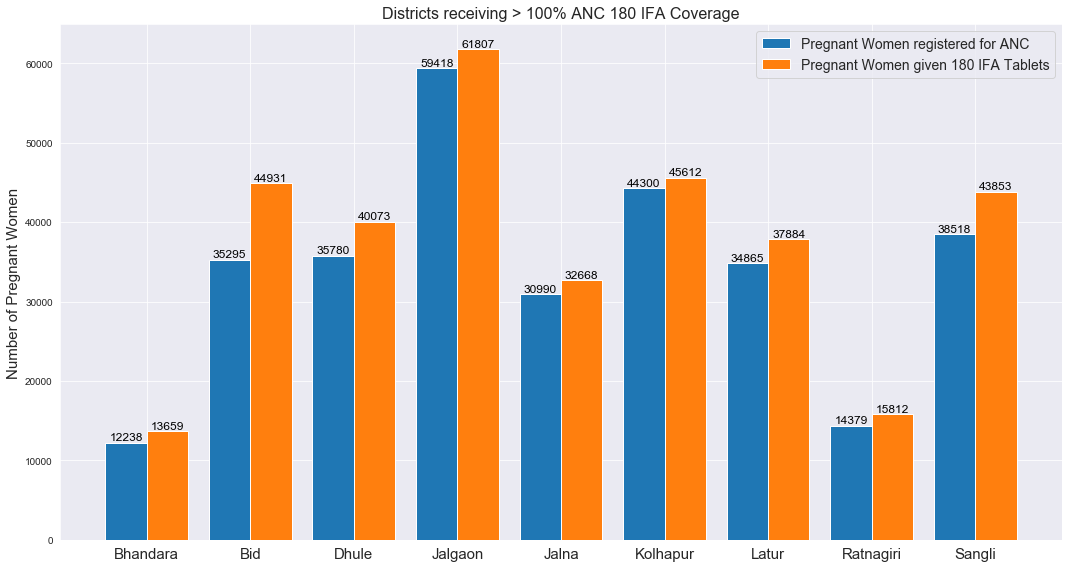

In [330]:
sb.set_style('darkgrid')

# specify the number of districts for which the data is to be plotted
N = 9

# separate out the rows where IFA coverage is greater than 100
# also, separate out the number of women registered and the number of women given tablets
registered_anc = df1[df1['% Pregnant women given 180 IFA to Total ANC Registration'] > 100]['Total number of pregnant women Registered for ANC'].values
given_ifa = df1[df1['% Pregnant women given 180 IFA to Total ANC Registration'] > 100]['Number of Pregnant women given 180 IFA tablets'].values

ind = np.arange(N)  # the x locations for the groups
width = 0.4         # the width of the bars

# plot
fig, ax = plt.subplots(figsize = (15, 8))
rects1 = ax.bar(ind, registered_anc, width, color=sb.color_palette()[0])
rects2 = ax.bar(ind + width, given_ifa, width, color=sb.color_palette()[1])

# label the plot
ax.set_ylabel('Number of Pregnant Women', fontsize = 15)
ax.set_title('Districts receiving > 100% ANC 180 IFA Coverage', fontsize = 16)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(df1[df1['% Pregnant women given 180 IFA to Total ANC Registration'] > 100].index.get_level_values(level = 0), fontsize = 15)

# add legend
ax.legend((rects1[0], rects2[0]), ('Pregnant Women registered for ANC', 'Pregnant Women given 180 IFA Tablets'), fontsize = 14)
plt.tight_layout()

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                '%d' % int(height),
                ha='center', va='bottom', fontsize = 12, color = 'black')

# annotate the bars
autolabel(rects1)
autolabel(rects2)

# save the figure
plt.savefig('accuracy_error.png')

***

## Outliers

Here we exclude the data for Maharashtra since it will always be an outlier. It is correct to exclude it since it is an aggregated row and not an independent one.

In [49]:
df2 = dfr.drop('_Maharashtra')

Select a column that has outliers. In this case, select the indicator `Number of Vasectomies Conducted`. Also, get the instances of the indicator that have a Z-score greater than 1.5:

In [50]:
x = 'Number of Vasectomies Conducted'

df2[x][abs(stats.zscore(df2[x])) > 1.5]

state          year   
Bhandara       2017-18     880.0
Brihan Mumbai  2017-18     867.0
Gadchiroli     2017-18    2142.0
               2018-19    1143.0
Gondiya        2017-18     978.0
               2018-19     763.0
Nashik         2017-18     762.0
               2018-19     878.0
Name: Number of Vasectomies Conducted, dtype: float64

Check if any of the outliers lies more than 3 Standard Deviations away from the mean:

In [51]:
df2[x][abs(stats.zscore(df2[x])) > 3]

state       year   
Gadchiroli  2017-18    2142.0
Name: Number of Vasectomies Conducted, dtype: float64

Make a boxplot for the `Number of Vasectomies Conducted`:

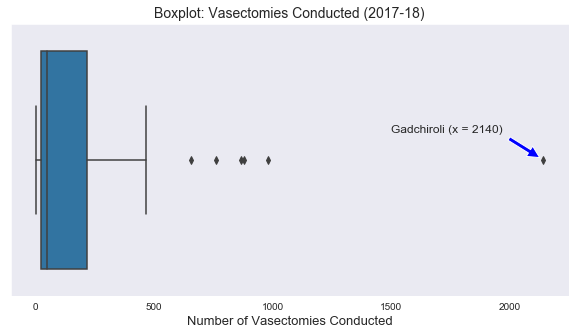

In [167]:
sb.set_style('dark')

# plot
plt.figure(figsize = (10, 5))
sb.boxplot(x = df2.xs('2017-18', level = 'year')['Number of Vasectomies Conducted'].values)

# label the plot
plt.title('Boxplot: Vasectomies Conducted (2017-18)', fontsize = 14)
plt.xlabel('Number of Vasectomies Conducted', fontsize = 13)

# mark the outlier 'Gadchiroli' since it is more than 3 sd's away from the mean
plt.annotate('Gadchiroli (x = 2140)', xy=(2142.0, 0), xytext=(1500, -0.1),
            arrowprops=dict(facecolor='blue', shrink=0.09), fontsize = 12)

# save the figure
plt.savefig('outliers.png')

***

# NULL's vs. 0's

Here we will look for examples where a 0 value has been confused with a NULL. <br>
Select an indicator that has both null values and zeros. In this case, `Number of Women Discharged under 48 hours of delivery in private institutions`:

In [43]:
# select entries with 0 for the indicator
c = dfr['Number of Women Discharged under 48 hours of delivery in private institutions'][dfr['Number of Women Discharged under 48 hours of delivery in private institutions'].eq(0)]

# select entries with NULLs for the indicator
d = dfr['Number of Women Discharged under 48 hours of delivery in private institutions'][dfr['Number of Women Discharged under 48 hours of delivery in private institutions'].isnull()]

# concatenate both Series
df5 = pd.DataFrame(pd.concat([c,d]))
df5

Number of Women Discharged under 48 hours of delivery in private institutions
state      year                                                                                  
Akola      2017-18                                                0.0                            
           2018-19                                                0.0                            
Bhandara   2017-18                                                0.0                            
Bid        2017-18                                                0.0                            
Chandrapur 2018-19                                                0.0                            
Nanded     2017-18                                                0.0                            
Satara     2018-19                                                0.0                            
Wardha     2017-18                                                0.0                            
           2018-19                                                0.0                            
Jalgaon    2017-18                                                NaN                            
Latur      2017-18                                                NaN

In [44]:
# store the result
df5.to_csv('nans_and_zeros.csv')